In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [3]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [4]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './extend/fog_dataset_extend.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]

# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(63311, 15)
(63311,)


In [5]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled  = scaler.fit_transform(test_x)

train_x_scaled[:,0:3] = train_x[:,0:3]
train_x_scaled[:,-5:-1] = train_x[:,-5:-1]
valid_x_scaled[:,0:3]   = valid_x[:,0:3]
valid_x_scaled[:,-5:-1] = valid_x[:,-5:-1]
test_x_scaled[:,0:3]    = test_x[:,0:3]
test_x_scaled[:,-5:-1]  = test_x[:,-5:-1]

In [ ]:
print(np.max(train_x_scaled[:,-5]), np.min(train_x_scaled[:,-5]))

In [6]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=train_x.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4)]
history = sklearn_model.fit(train_x_scaled, train_y,
                            epochs = 100,
                            validation_data = (valid_x_scaled, valid_y),
                            callbacks = callbacks)

C:\Users\Henry\AppData\Local\Temp\ipykernel_7592\2167092788.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasRegressor(


Epoch 1/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.3122 - val_loss: 0.3003
Epoch 2/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.2289 - val_loss: 0.3083
Epoch 3/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.2147 - val_loss: 0.3186
Epoch 4/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.2076 - val_loss: 0.3208
Epoch 5/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.2026 - val_loss: 0.3414
Epoch 6/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1988 - val_loss: 0.3531


In [7]:
from scipy.stats import reciprocal

# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4, 5, 6, 7],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=0.5e-4)]
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(train_x_scaled, train_y, epochs = 100,
                     validation_data = (valid_x_scaled, valid_y),
                     callbacks = callbacks)

Epoch 1/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.2646 - val_loss: 0.2482
Epoch 2/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1898 - val_loss: 0.2239
Epoch 3/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1710 - val_loss: 0.2323
Epoch 4/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1600 - val_loss: 0.2317
Epoch 5/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1519 - val_loss: 0.2050
Epoch 6/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1454 - val_loss: 0.2165
Epoch 7/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1418 - val_loss: 0.2141
Epoch 8/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1377 - val_loss: 0.2208
Epoch 9/100
1319/1319 [==============================] - 4s 3ms/step - loss: 0.1343 - val_loss: 0.2135
Epoch 10/100
1319/1319 [==============================] - 4s 3ms/step - l

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000295085BFE50>,
                   n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4, 5, 6, 7],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000295087EDA60>})

In [8]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model = random_search_cv.best_estimator_.model
model.evaluate(test_x_scaled, test_y)

{'hidden_layers': 7, 'layer_size': 98, 'learning_rate': 0.008774044148026733}
-0.10440551489591599
467/467 [==============================] - 1s 2ms/step - loss: 0.2446


0.2446470409631729

In [ ]:

model_path = os.path.join(file_dir, './seafog_hpsearch_reg.h5')
tf.keras.models.save_model(
    model, model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

In [ ]:
train_x_scaled.shape[1:]

In [12]:
model.layers

In [13]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 98)                1568      
                                                                 
 dense_141 (Dense)           (None, 98)                9702      
                                                                 
 dense_142 (Dense)           (None, 98)                9702      
                                                                 
 dense_143 (Dense)           (None, 98)                9702      
                                                                 
 dense_144 (Dense)           (None, 98)                9702      
                                                                 
 dense_145 (Dense)           (None, 98)                9702      
                                                                 
 dense_146 (Dense)           (None, 98)              

In [ ]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [ ]:
type(history)

In [ ]:
history.history

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.2446470409631729

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3
* hp 搜索后MSE达到了0.245

In [9]:
predictions = model(test_x_scaled).numpy()
predictions

array([[0.3199273 ],
       [0.42130622],
       [0.41223577],
       ...,
       [2.2620242 ],
       [2.6280146 ],
       [2.5198727 ]], dtype=float32)

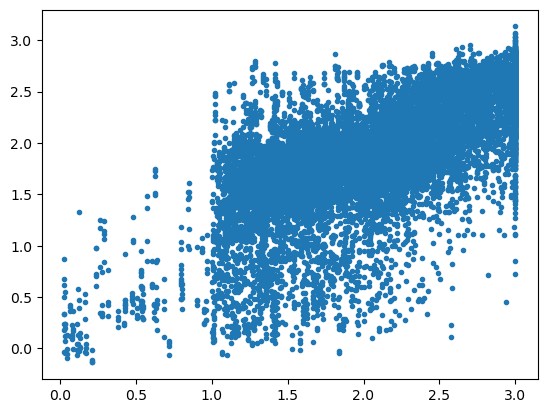

In [10]:
plt.plot(test_y, predictions,'.')
plt.show()

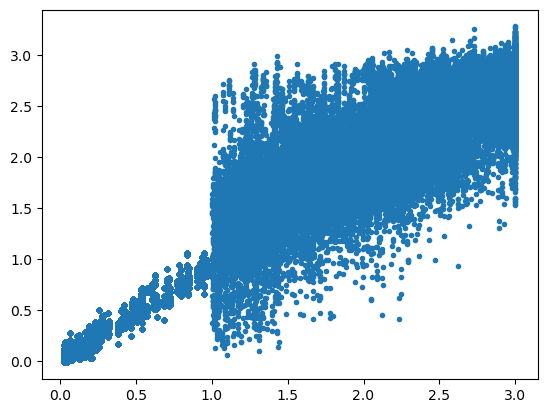

In [11]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 